In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc

In [15]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/clustered.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata.uns['X_umap'] = adata.obsm['X_umap']
adata

AnnData object with n_obs × n_vars = 8562 × 14972
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id'
    uns: 'clusters', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags', 'X_umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

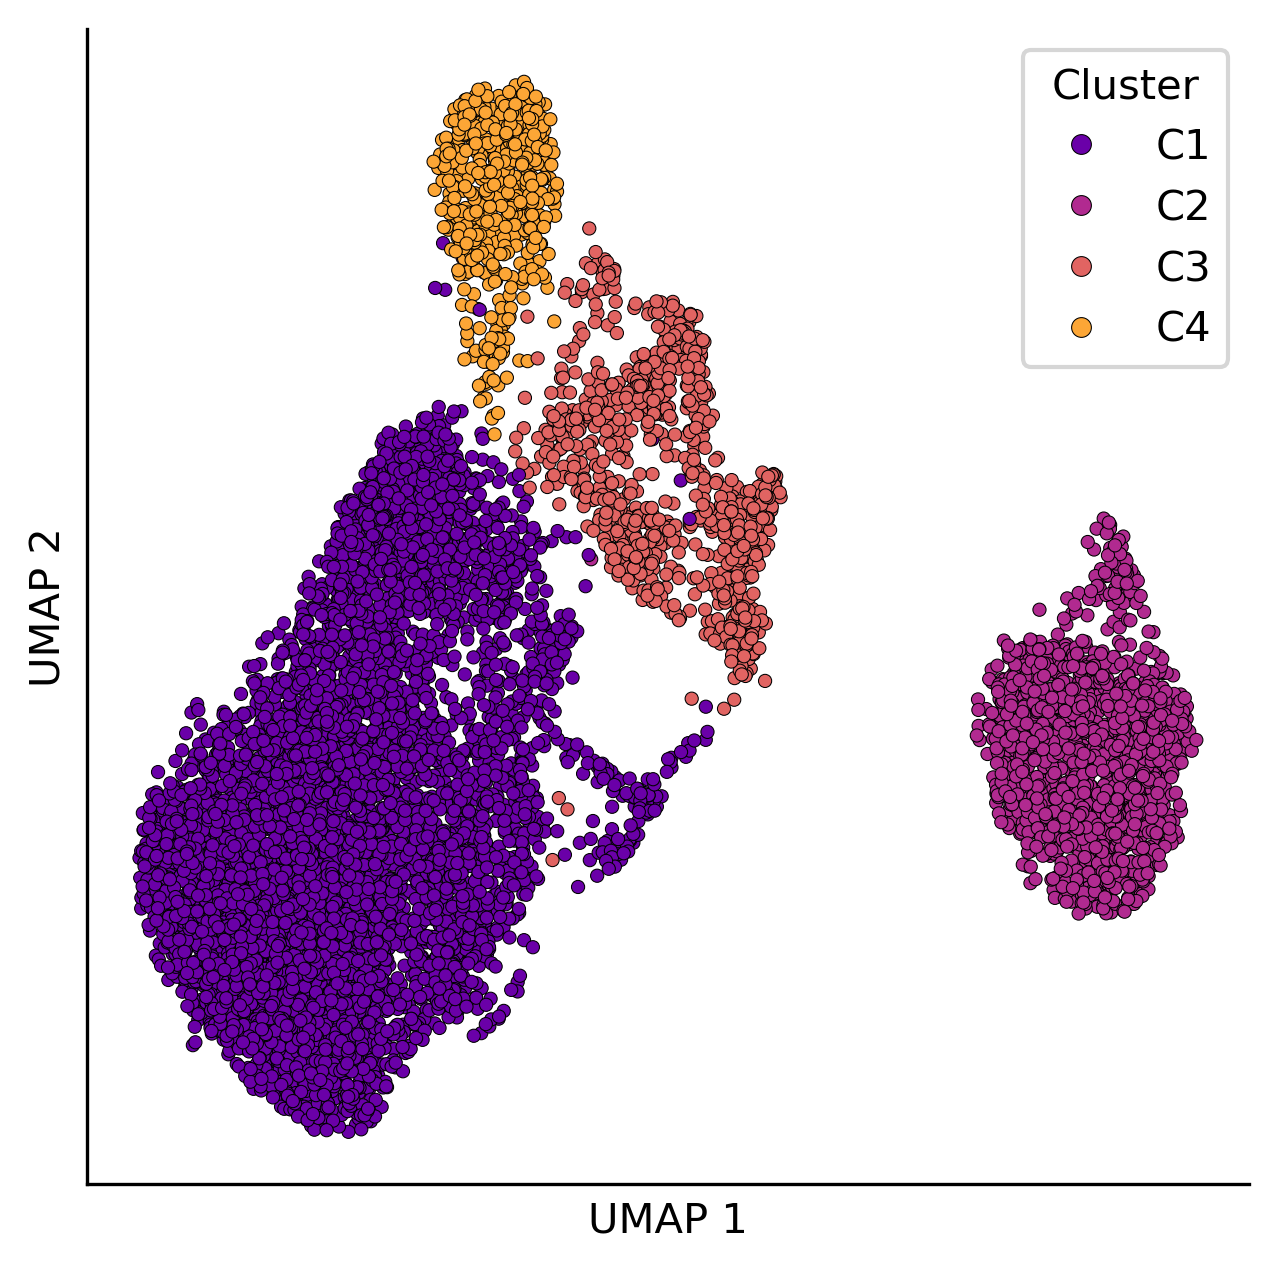

In [20]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

min_dist = 0.75
spread = 1.75

sc.tl.umap(adata, 
           min_dist=min_dist, 
           spread=spread)

resolution = "r10"
cluster_labels = adata.uns['clusters'][resolution].apply(lambda x: f"C{int(x)+1}")

sns.scatterplot(data=adata.obs,
                x=adata.obsm['X_umap'][:, 0],
                y=adata.obsm['X_umap'][:, 1],
                ec='k',
                hue=cluster_labels,
                palette='plasma',
                s=10,)

sns.despine()
plt.xticks([])
plt.yticks([])
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

sns.move_legend(plt.gca(), 
                title="Cluster",
                loc='best',
                markerscale=1.5)

In [53]:
def plot_umap_scatter(
    adata, color="CD34", 
    cmap="viridis",
    vmin=None,
    vmax=None,
    label=True,
    **kwargs
) -> plt.Axes:
    """
    Creates a scatterplot of UMAP data from an AnnData object with color mapping and a colorbar.

    Args:
        adata (anndata.AnnData): The AnnData object containing the UMAP embedding and color data.
        color (str, optional): Column name in `adata.var` or `adata.obs` for color mapping (default: "CD34").
        cmap (str or matplotlib.colors.Colormap, optional): Colormap to use (default: "viridis").
        vmin (float, optional): Minimum value for colormap normalization (default: None).
        vmax (float, optional): Maximum value for colormap normalization (default: None).
        **kwargs: Additional keyword arguments passed to `plt.scatter`.

    Returns:
        matplotlib.axes.Axes: The Axes object containing the plot.

    Raises:
        KeyError: If `color` is not found in `adata.var` or `adata.obs`.
    """

    if color in adata.var_names:  # Color is a gene expression value
        df = adata.to_df()
        expression = df[color].values  
    elif color in adata.obs:
        expression = adata.obs[color].values
    else:
        raise KeyError(f"Color key '{color}' not found in adata.var or adata.obs")

    # Sort points for smooth colorbar
    order = np.argsort(expression)

    # Determine vmin and vmax if not provided
    if vmin is None:
        vmin = np.min(expression)
    if vmax is None:
        vmax = np.max(expression)

    # Create scatterplot with normalized colormap
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        adata.obsm['X_umap'][:, 0][order],
        adata.obsm['X_umap'][:, 1][order],
        c=expression[order],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        **kwargs
    )

    # Add colorbar
    cbar = plt.colorbar(scatter, shrink=0.4, ax=ax)

    # Additional formatting
    sns.despine(ax=ax)
    
    if label:
        x_label = 'UMAP 1'
        y_label = 'UMAP 2'
    else:
        x_label = ''
        y_label = ''
        
    ax.set(
        xlabel=x_label,
        ylabel=y_label,
        xticks=[],
        yticks=[]
    )

    return ax

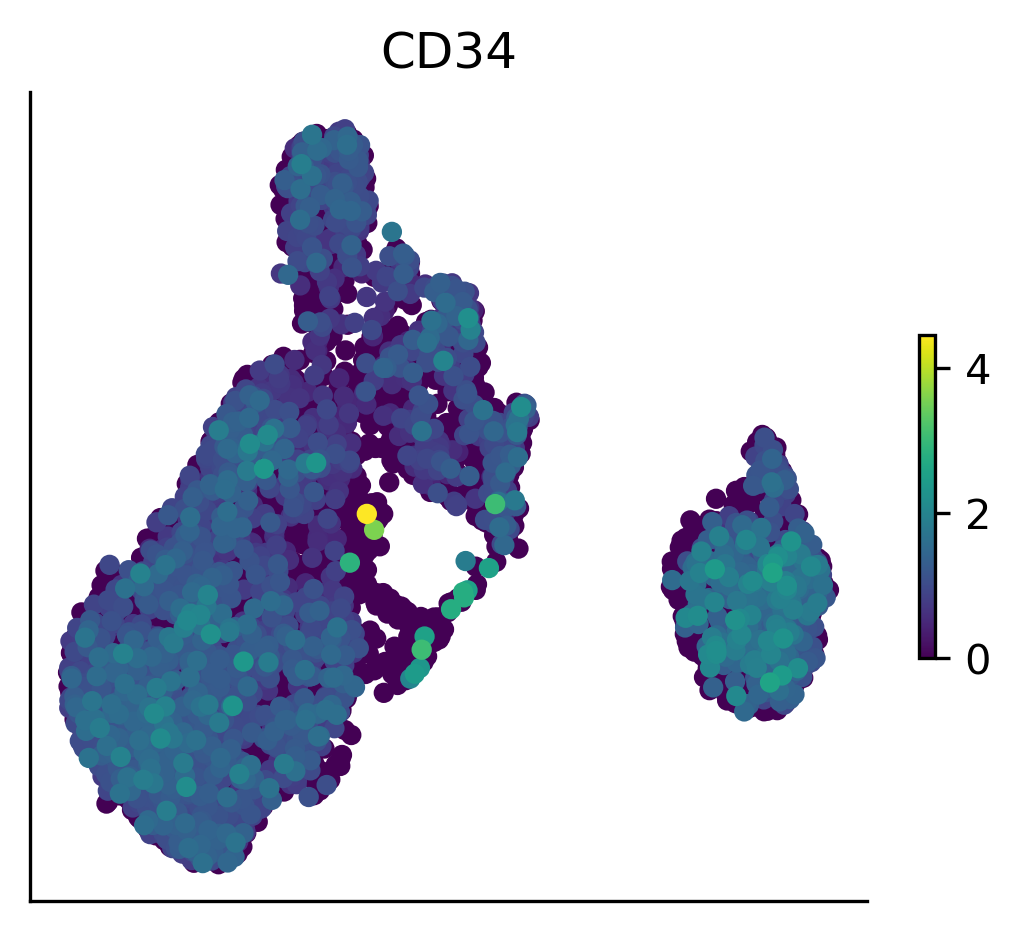

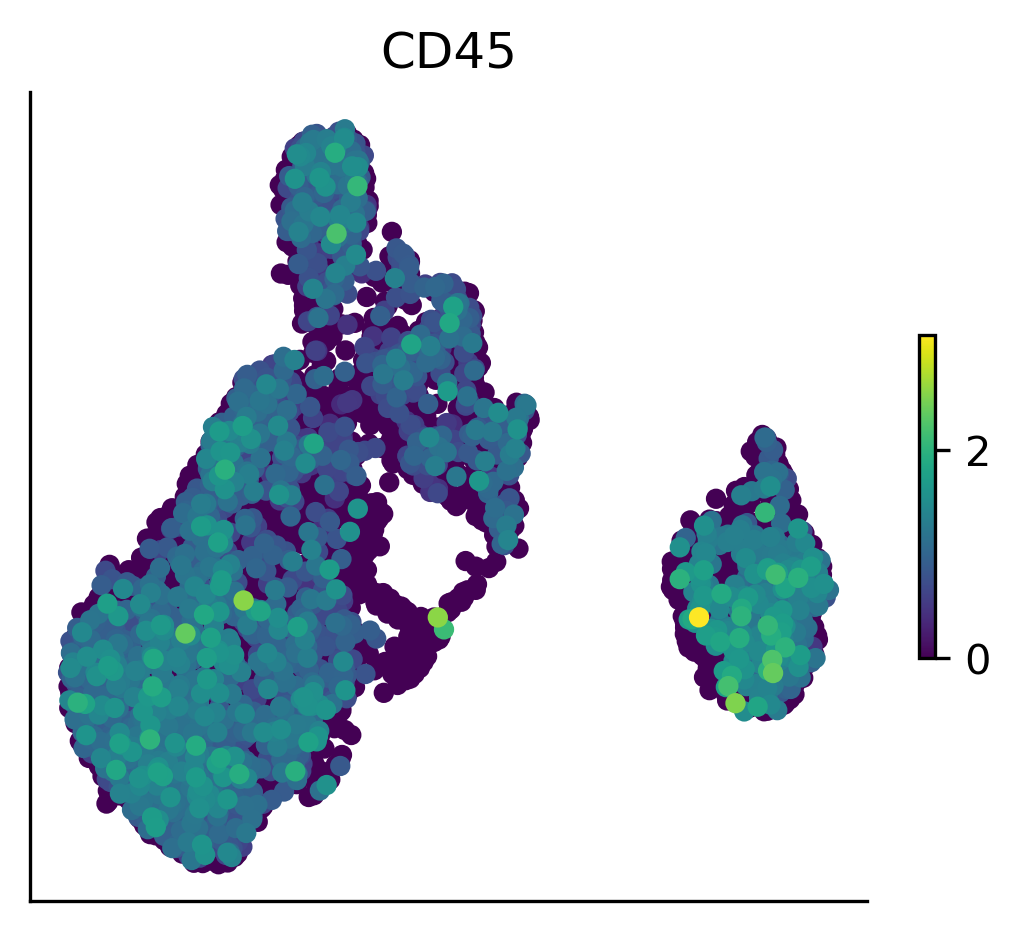

In [54]:
adata.var_names = adata.var['gene_name'].values

gene_list = {
    'CD34' : 'CD34',
    'PTPRC' : 'CD45',
}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 3.5

for gene_name, gene_label  in gene_list.items():
    plot_umap_scatter(adata, 
                      s=15, 
                      label=False,
                      color=gene_name)
    plt.title(gene_label)
    plt.show()
    

Text(0.5, 1.0, 'HSC Marker Genes')

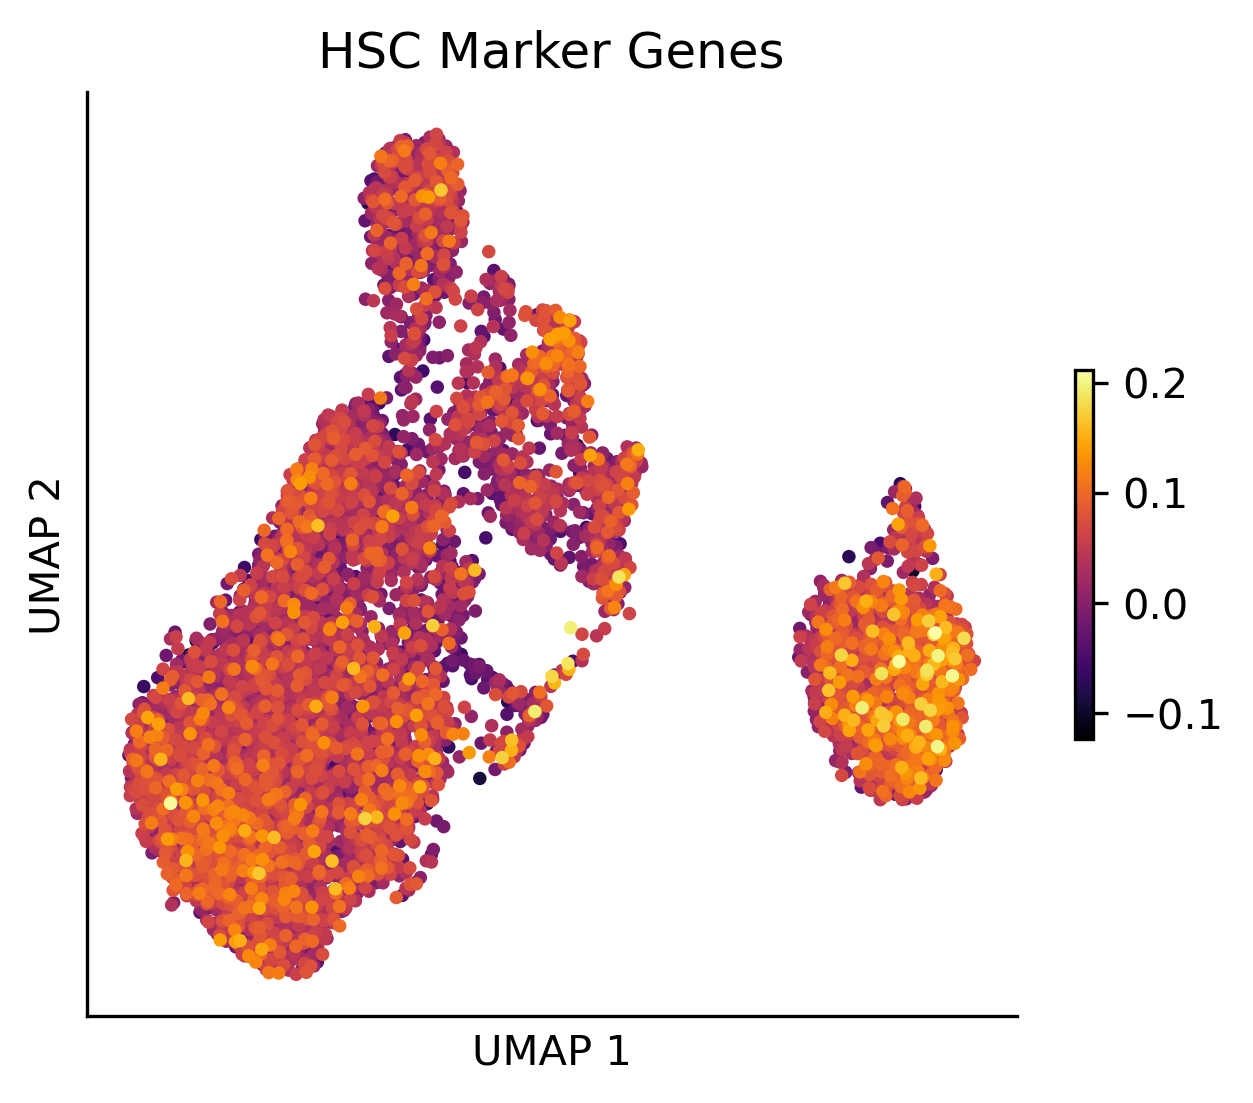

In [55]:
db = 'panglaodb'
column = 'cell_type'
value = 'Hematopoietic stem cells'
genes = adata.uns[db][adata.uns[db][column] == value]['gene_name'].values
gene_ids = adata.var[adata.var['gene_name'].isin(genes)].index

sc.tl.score_genes(adata,
                  gene_list=gene_ids, 
                  ctrl_size=len(gene_ids),
                  score_name=value)

adata.obs[value] = adata.obs[value]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4

plot_umap_scatter(adata, 
                  s=5, 
                  cmap='inferno',
                  color=value)

plt.title(f"HSC Marker Genes")

In [56]:
def calculate_gene_expression_stats(df):
    """
    Calculates aggregate gene expression statistics for a given DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame with cells as rows and genes as columns.

    Returns:
        pd.DataFrame: A DataFrame with one row per gene, containing aggregated statistics.
    """

    # Aggregate statistics
    stats = pd.DataFrame({
        'average_expression': df.mean(),
        'median_expression': df.median(),
        'std_dev': df.std(ddof=0),  # Sample standard deviation
        'num_nonzero_cells': (df > 0).sum(),
        'percent_nonzero': 100 * (df != 0).mean()
    })

    # Round percent_nonzero to 2 decimal places
    stats['percent_nonzero'] = stats['percent_nonzero'].round(2)
    stats = stats.sort_values(by='average_expression', ascending=False)

    return stats

Text(0.5, 0, '')

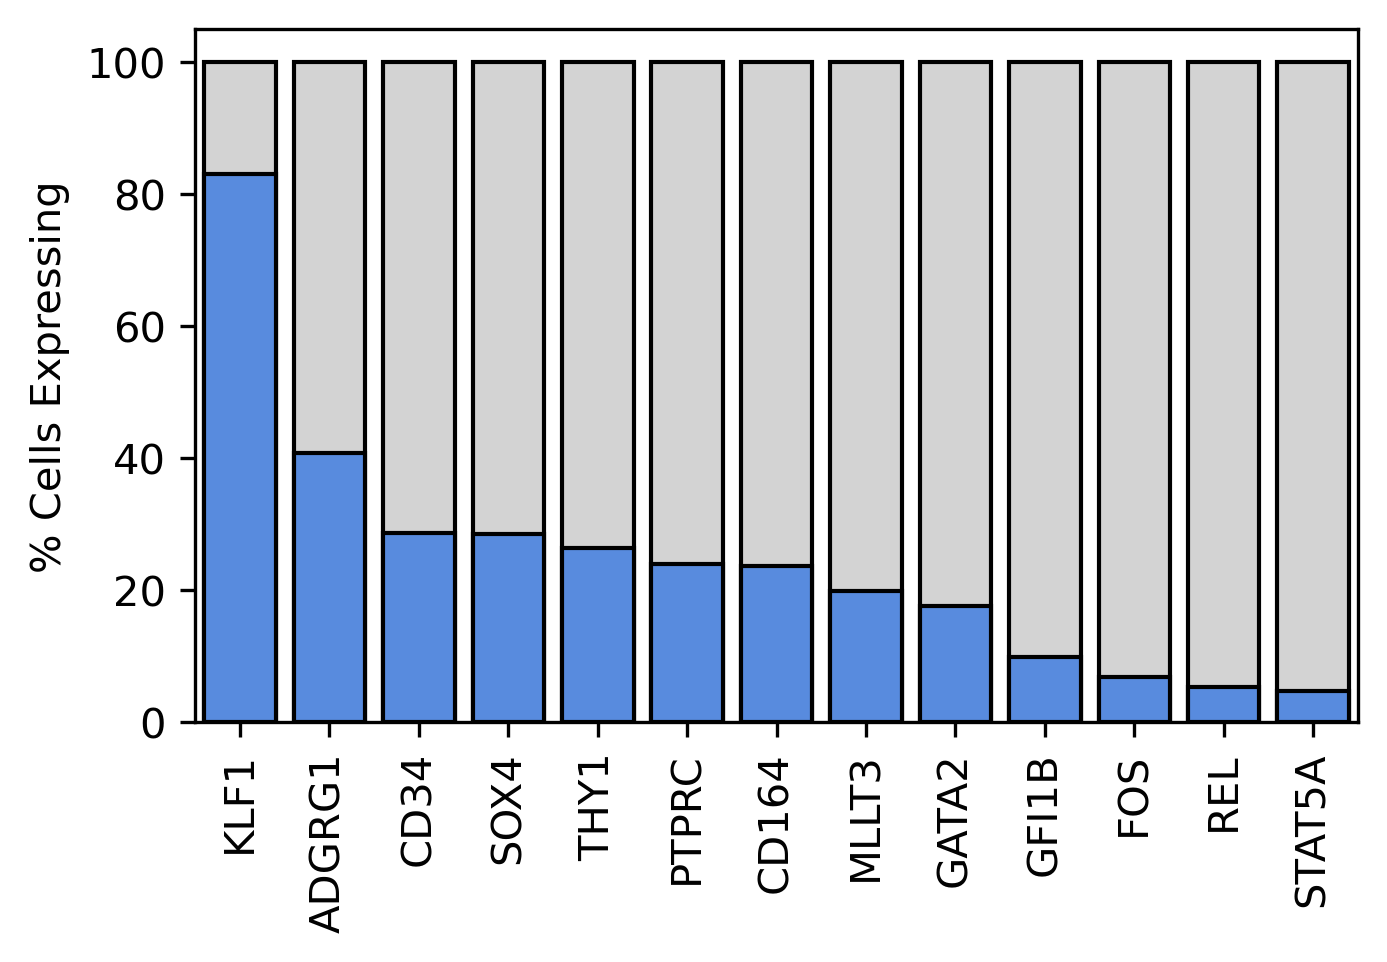

In [183]:

gene_list = [
    'CD34',
    'CD164',
    'THY1',
    'ADGRG1',
    'MLLT3',
    'PTPRC',
    'GATA2', 
    'SOX4',
    'GFI1B', 
    'REL', 
    'STAT5A', 
    'FOS',
    'KLF1',
]

genes = adata.var[adata.var['gene_name'].isin(gene_list)]

data = adata.to_df()
data = data[genes.index]
data.columns = genes['gene_name'].values
res = calculate_gene_expression_stats(data)
res = res.reset_index()
res['backblock'] = 100

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 3

sns.barplot(data=res, 
            x='index',
            y='backblock',
            color='lightgrey',
            ec='k')

sns.barplot(data=res, 
            x='index',
            y='percent_nonzero',
            color='#4285F4',
            ec='k')


plt.gca().tick_params(axis='x', rotation=90)

plt.ylabel("% Cells Expressing")
plt.xlabel("")

# DEG Analysis

In [78]:
resolution = "r10"
cluster_labels = adata.uns['clusters'][resolution].apply(lambda x: f"C{int(x)+1}")
adata.obs['cluster_labels'] = cluster_labels

sc.tl.rank_genes_groups(adata, 
                        groupby="cluster_labels",
                        method='wilcoxon',
                        corr_method='benjamini-hochberg',
                        pts=True,
                        key_added='deg',
                       )

deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='deg')

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,C1,TOMM70,61.153011,3.165508,0.0,0.0,0.978866,0.638696
1,C1,CEACAM3,58.738014,1.075220,0.0,0.0,0.999824,1.000000
2,C1,ZSWIM6,57.812565,2.863965,0.0,0.0,0.970940,0.699376
3,C1,LILRA1,56.661018,2.156720,0.0,0.0,0.986615,0.944521
4,C1,AP5M1,54.453121,2.555322,0.0,0.0,0.944347,0.523925


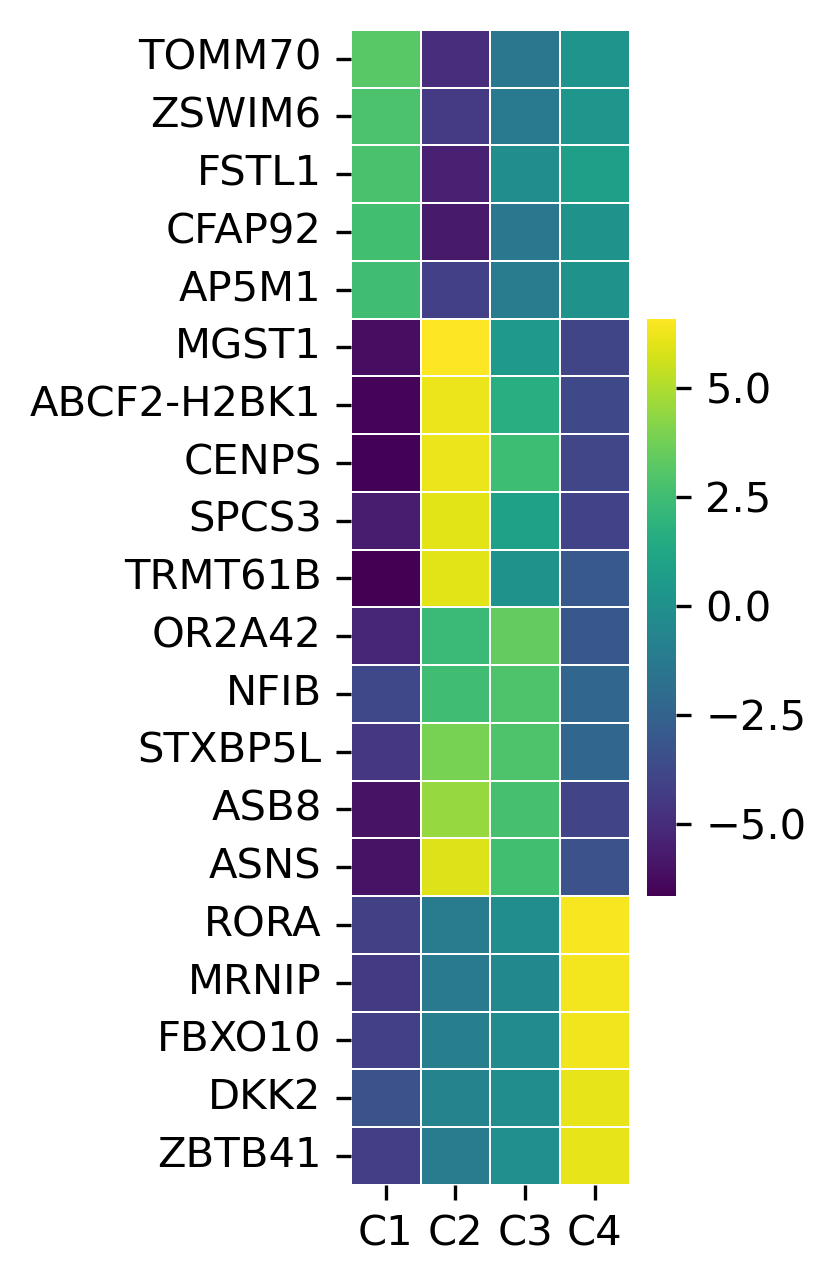

In [163]:
def top_n_de_genes(df, n=10, alpha=0.05, pct_nz_threshold=0.25, pct_nz_reference=0.90, values='logfoldchanges', gene_list=None):
    """
    Returns the top N differentially expressed genes for each group, ranked by absolute log fold change.

    Args:
        df (pd.DataFrame): DataFrame containing DE analysis results.
        n (int, optional): Number of top genes per group (default: 10).
        alpha (float, optional): Significance level (default: 0.05).
        pct_nz_threshold (float, optional): Min. proportion expressed in group (default: 0.25).
        pct_nz_reference (float, optional): Max. proportion expressed in reference (default: 0.90).
        values (str, optional): Pivot table values to fill (default: 'logfoldchanges')

    Returns:
        pd.DataFrame: A pivot table of log fold changes where rows are groups, columns are names, and values are logfoldchanges
    """

    # Filter by significance and expression percentage
    df_filtered = df.query(
        f"`pvals_adj` <= {alpha} and `pct_nz_group` >= {pct_nz_threshold} and `pct_nz_reference` <= {pct_nz_reference}"
    )
    
    if not gene_list is None:
        df_filtered = df_filtered[df_filtered['names'].isin(gene_list)]

    # Sort by log fold change within each group (descending order for top genes)
    df_sorted = df_filtered.sort_values(
        ['group', 'logfoldchanges'], ascending=[True, False]
    )

    # Group by and select top N rows
    top_genes = df_sorted.groupby('group').head(n)['names'].values

    table = df[df['names'].isin(top_genes)]

    table = pd.pivot_table(
        table,
        index='group',
        columns='names',
        values=values
    )
    
    table = table[top_genes]

    return table


cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.5
pct_nz_reference = 0.90

table = top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 5

sns.heatmap(table.T, 
            cmap=cmap, 
            lw=0.1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

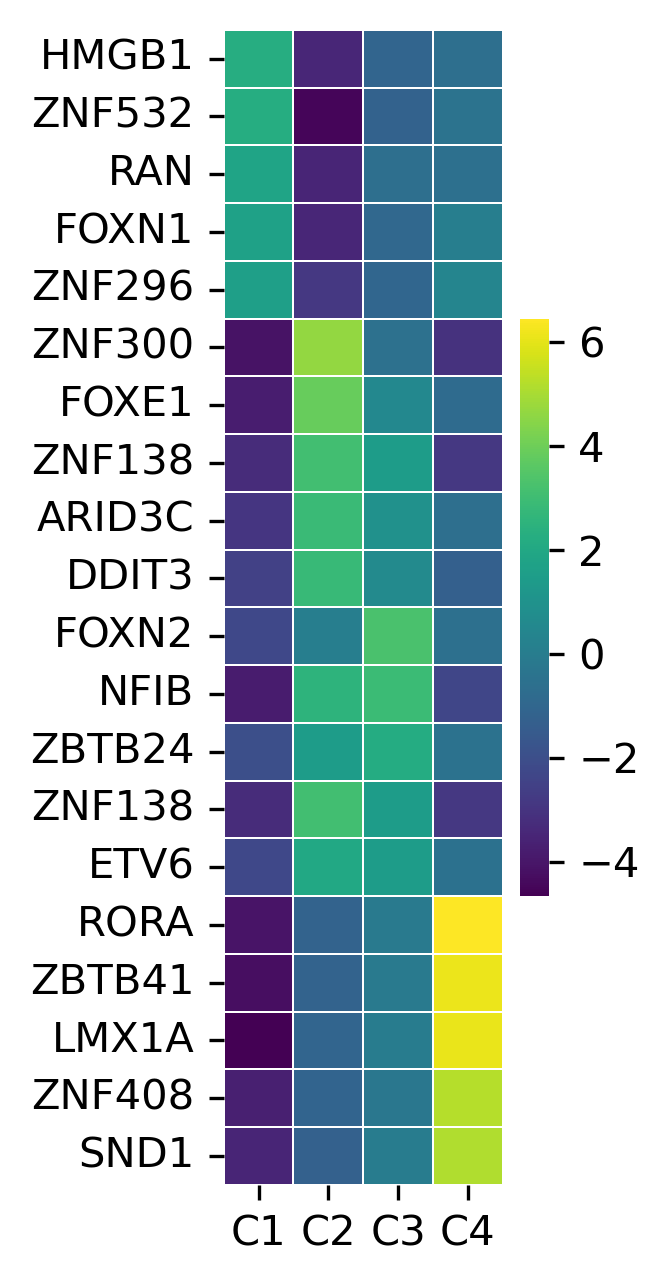

In [173]:
cmap = 'viridis'
n_genes = 5
values = 'logfoldchanges'
pct_nz_threshold = 0.25
pct_nz_reference = 0.5

table = top_n_de_genes(deg, 
                       n=n_genes, 
                       pct_nz_threshold=pct_nz_threshold,
                       pct_nz_reference=pct_nz_reference,
                       values=values,
                       gene_list=adata.uns['scenic_transcription_factors']['gene_name'].values)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 5

sns.heatmap(table.T, 
            cmap=cmap, 
            lw=0.1,
            cbar_kws={'shrink' : 0.5})

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)

In [166]:
adata.uns['scenic_transcription_factors']['gene_name'].values

array(['ZNF143', 'ZIC2', 'ZNF274', ..., 'ZNF717', 'ZNF827', 'ZNF831'],
      dtype=object)

In [84]:
pvals_adj = 0.05
logfoldchanges = 1.0

sig = deg.copy()
sig = sig[sig['pvals_adj'] <= pvals_adj]
sig = sig[sig['logfoldchanges'] > logfoldchanges]

print(f"{sig.shape=}")
sig['group'].value_counts()

sig.shape=(2104, 8)


group
C4    788
C2    682
C3    323
C1    311
Name: count, dtype: int64

In [104]:
sig.columns

Index(['group', 'names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj',
       'pct_nz_group', 'pct_nz_reference'],
      dtype='object')

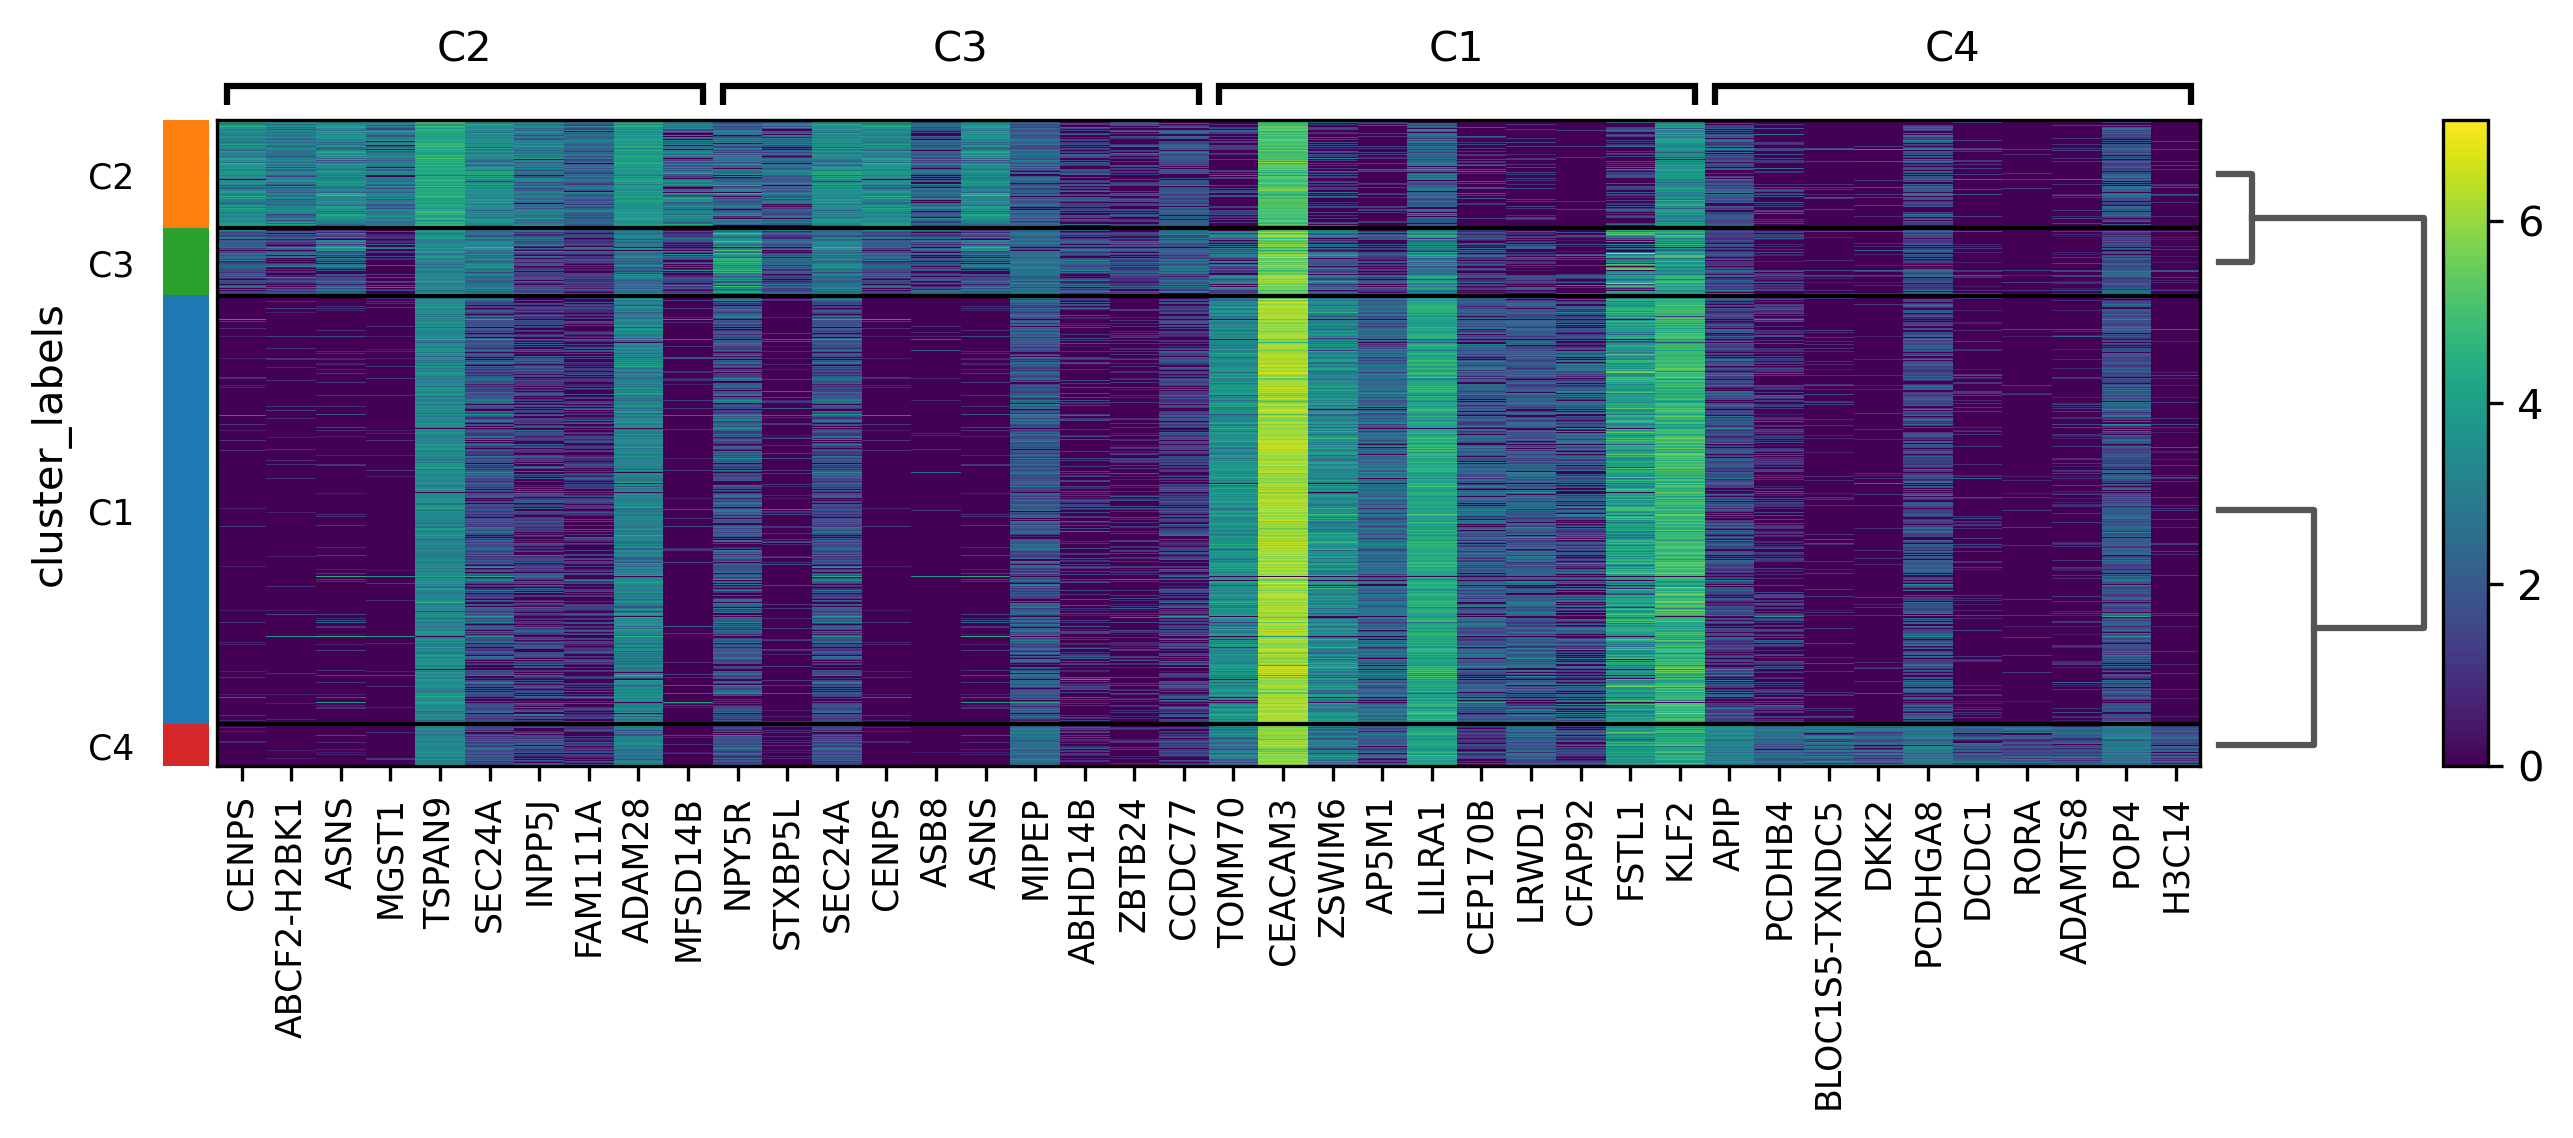

In [103]:
sc.pl.rank_genes_groups_heatmap(adata, 
                                n_genes=10,
                                min_logfoldchange=1.0, 
                                figsize=(10,3))